# Setting up Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [65]:
# !git clone https://github.com/anubhabPanda/Picasso.git
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/anubhabPanda/Picasso
   eabb8d7..8bd76f0  master     -> origin/master
Updating eabb8d7..8bd76f0
Fast-forward
 utilities/utils.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [6]:
os.chdir('Picasso')

In [17]:
zip_path = "/content/drive/My Drive/Picasso/tiny-imagenet-200.zip"

In [19]:
!cp "{zip_path}" .

In [21]:
!unzip -q tiny-imagenet-200.zip

In [23]:
!rm tiny-imagenet-200.zip

In [24]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 7.2MB/s 
     |████████████████████████████████| 952kB 13.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=ebaf207c0e3e126d4aa0c92dc867e496904690e57b05ccb8f0cbe4cec4138394
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Imports

In [25]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import os
from utilities import utils, config, cuda, save_load
from dataset import dataset
from main_engine import engine, schedulers
from models import resnet
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from gradcam import GradCAMView
from main_engine.lr_finder import LRFinder
from dataset.tinyimagenet import TinyImageNetDataset
import cv2

In [26]:
#Initialize cuda
cuda, device = cuda.initialize_cuda(config.SEED)

GPU Available? True


# Visualize Dataset

In [27]:
imagenet_dataset = dataset.tinyimagenet_dataset('tiny-imagenet-200', download=False)

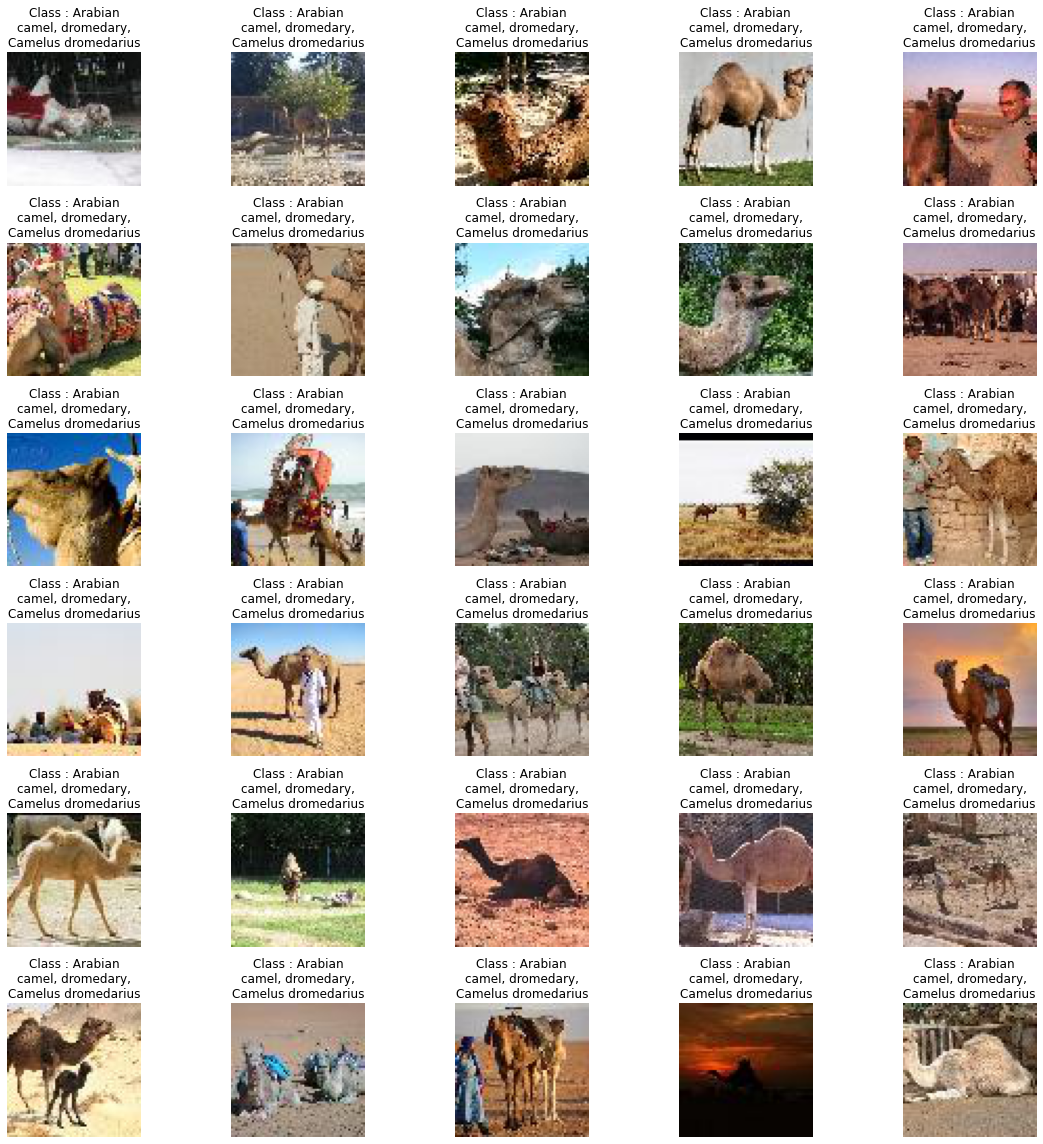

In [28]:
utils.show_imgs(imagenet_dataset, 30, (16, 16))

# Create DataLoader and Transformations

In [29]:
config.BATCH_SIZE = 512
config.EPOCHS = 50

In [30]:
mean, std = utils.get_stats(imagenet_dataset)[0], utils.get_stats(imagenet_dataset)[1]
print(mean, std)

(0.0372, 0.0372, 0.0372) (0.277, 0.2691, 0.2822)


In [31]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [
                      A.PadIfNeeded(min_height=68, min_width=68, border_mode = cv2.BORDER_REFLECT, always_apply=True),
                      A.RandomCrop(height=64, width=64, always_apply=True),
                      A.HorizontalFlip(p=0.4),
                      A.Cutout(1,32, 32, fill_value=mean, p=0.3)
                     ]

In [32]:
trainset = dataset.tinyimagenet_dataset('tiny-imagenet-200', download=False, transforms=transformations_list, augmentations=augmentations_list)
testset = dataset.tinyimagenet_dataset('tiny-imagenet-200', download=False, transforms=transformations_list, train = False)
train_dl = dataset.data_loader(trainset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)

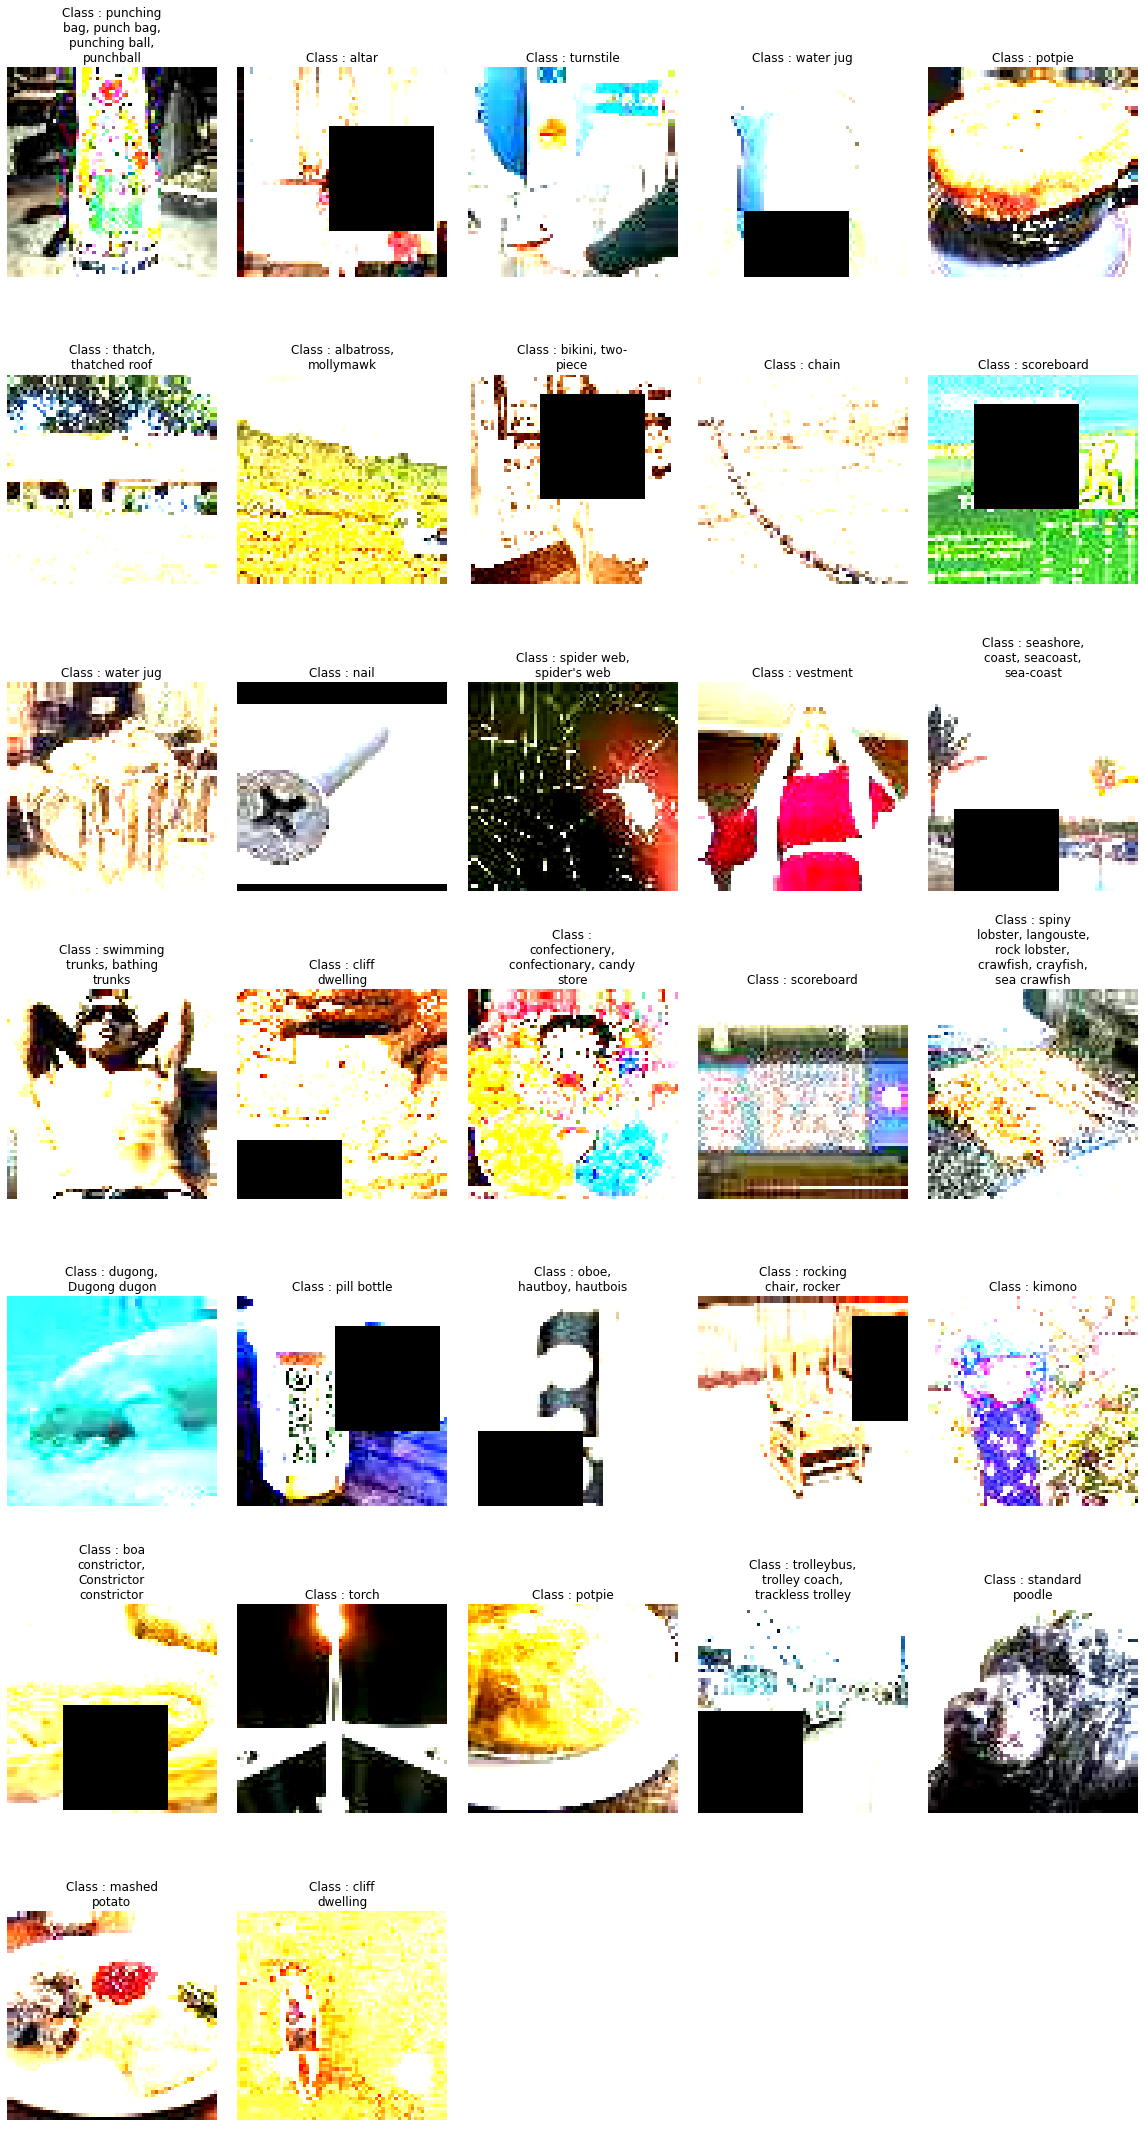

In [33]:
utils.show_batch(train_dl, (16, 30))

# Model Architecture

In [34]:
#Define model
model = resnet.ResNet18(num_classes=200).to(device)
utils.summary(model, (3, 64, 64))

torch.Size([2, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-

# Model Training

In [44]:
model = resnet.ResNet18(num_classes=200).to(device)
loss_fn = utils.cross_entropy_loss_fn()
optimizer = utils.sgd_optimizer(model, lr=0.01, momentum=0.9)
if config.DEBUG == True:
    config.EPOCHS = 20

scheduler = schedulers.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-5)
test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{config.EPOCHS}\n")
    engine.train(model, train_dl, optimizer, loss_fn, device, train_losses, train_accuracy)
    engine.test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    scheduler.step(test_loss[epoch])

  0%|          | 0/215 [00:00<?, ?it/s]

Running Epoch 1/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0081, Accuracy: 12881/110000 (11.71%)

Running Epoch 2/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 22592/110000 (20.54%)

Running Epoch 3/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0065, Accuracy: 26677/110000 (24.25%)

Running Epoch 4/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 30608/110000 (27.83%)

Running Epoch 5/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0055, Accuracy: 36704/110000 (33.37%)

Running Epoch 6/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0058, Accuracy: 34774/110000 (31.61%)

Running Epoch 7/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0054, Accuracy: 38680/110000 (35.16%)

Running Epoch 8/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 45891/110000 (41.72%)

Running Epoch 9/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 48249/110000 (43.86%)

Running Epoch 10/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0040, Accuracy: 52872/110000 (48.07%)

Running Epoch 11/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0039, Accuracy: 54334/110000 (49.39%)

Running Epoch 12/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0040, Accuracy: 53368/110000 (48.52%)

Running Epoch 13/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0037, Accuracy: 57047/110000 (51.86%)

Running Epoch 14/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0037, Accuracy: 57365/110000 (52.15%)

Running Epoch 15/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0032, Accuracy: 62931/110000 (57.21%)

Running Epoch 16/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0030, Accuracy: 65990/110000 (59.99%)

Running Epoch 17/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0032, Accuracy: 63726/110000 (57.93%)

Running Epoch 18/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0029, Accuracy: 67476/110000 (61.34%)

Running Epoch 19/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0031, Accuracy: 64691/110000 (58.81%)

Running Epoch 20/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0027, Accuracy: 69493/110000 (63.18%)

Running Epoch 21/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0026, Accuracy: 70985/110000 (64.53%)

Running Epoch 22/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0026, Accuracy: 71301/110000 (64.82%)

Running Epoch 23/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0024, Accuracy: 73938/110000 (67.22%)

Running Epoch 24/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0023, Accuracy: 74969/110000 (68.15%)

Running Epoch 25/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0022, Accuracy: 76753/110000 (69.78%)

Running Epoch 26/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0020, Accuracy: 79520/110000 (72.29%)

Running Epoch 27/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0021, Accuracy: 76632/110000 (69.67%)

Running Epoch 28/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0020, Accuracy: 78678/110000 (71.53%)

Running Epoch 29/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0018, Accuracy: 82251/110000 (74.77%)

Running Epoch 30/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0018, Accuracy: 81694/110000 (74.27%)

Running Epoch 31/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0015, Accuracy: 86010/110000 (78.19%)

Running Epoch 32/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0016, Accuracy: 84538/110000 (76.85%)

Running Epoch 33/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0013, Accuracy: 88435/110000 (80.40%)

Running Epoch 34/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0014, Accuracy: 86806/110000 (78.91%)

Running Epoch 35/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 91306/110000 (83.01%)

Running Epoch 36/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0015, Accuracy: 85629/110000 (77.84%)

Running Epoch 37/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 92854/110000 (84.41%)

Running Epoch 38/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 92390/110000 (83.99%)

Running Epoch 39/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0010, Accuracy: 92998/110000 (84.54%)

Running Epoch 40/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0010, Accuracy: 94123/110000 (85.57%)

Running Epoch 41/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 95621/110000 (86.93%)

Running Epoch 42/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 95774/110000 (87.07%)

Running Epoch 43/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0006, Accuracy: 100877/110000 (91.71%)

Running Epoch 44/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0006, Accuracy: 99994/110000 (90.90%)

Running Epoch 45/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 94655/110000 (86.05%)

Running Epoch 46/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0006, Accuracy: 100708/110000 (91.55%)

Running Epoch 47/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0005, Accuracy: 101236/110000 (92.03%)

Running Epoch 48/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 98695/110000 (89.72%)

Running Epoch 49/50



  0%|          | 0/215 [00:00<?, ?it/s]


Validation set: Average loss: 0.0004, Accuracy: 104466/110000 (94.97%)

Running Epoch 50/50



Loss=0.40 Batch_ID=214 Accuracy=92.24: 100%|██████████| 215/215 [03:10<00:00,  1.13it/s]



Validation set: Average loss: 0.0003, Accuracy: 104936/110000 (95.40%)



In [45]:
#Saving Model
save_load.save_model(model, "EVA5S12.pth")

Model saving successful


In [51]:
model = resnet.ResNet18(num_classes=200).to(device)
model = save_load.load_model(model, "EVA5S12.pth")

In [52]:
one_batch = next(iter(test_dl))[0]
batch_imgs = []

for i in range(len(one_batch)):
    if i < 25:
        batch_imgs.append(one_batch[i])

# Misclassified Images

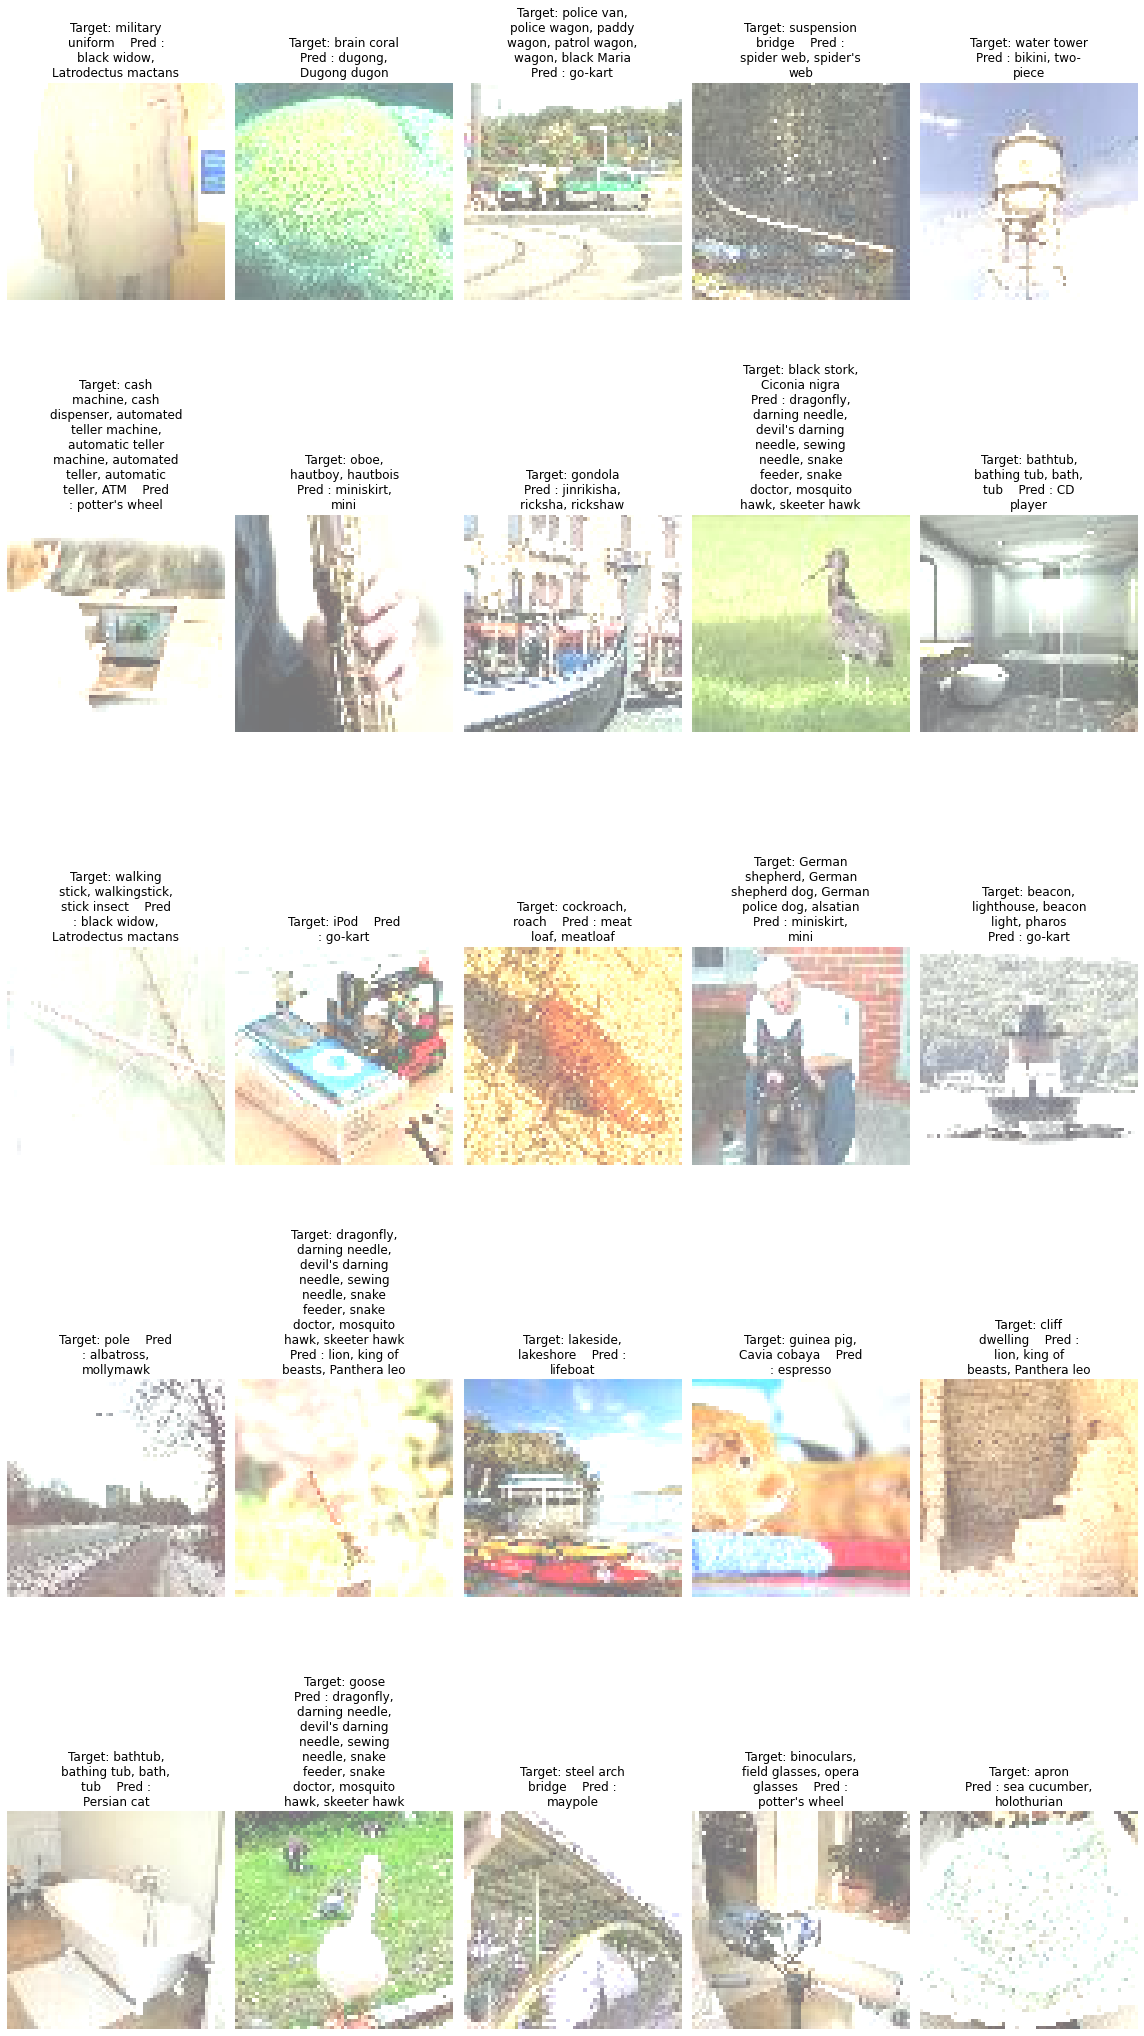

In [68]:
class_idx = trainset.class_to_idx
utils.plot_incorrect_images(misclassified_imgs, class_idx, plot_size=(16, 30))

# Validation Plots

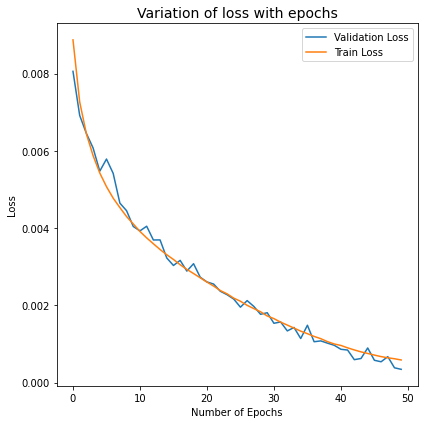

In [62]:
utils.plot_metrics([{'metric':test_loss, 'label':'Validation Loss'},
                    {'metric':train_losses, 'label':'Train Loss'}], "Loss")

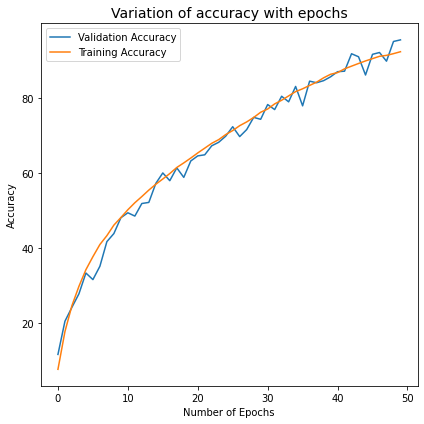

In [63]:
utils.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")